In [1]:
import os
os.environ['SPARK_HOME'] = '/etc/spark/'
os.environ['HADOOP_HOME'] = '/etc/hadoop/'
os.environ['PYSPARK_PYTHON'] = '/usr/bin/python3'

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
        .master("yarn") \
        .appName("Ddareungi") \
        .getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=yarn appName=Ddareungi>

<대여소정보>
 - 지역별(구 단위) 따릉이 대여소의 총 수/가장 많은 곳/가장 적은 곳는?
 - 지역별(구 단위) 따릉이 거치대의 총 수/가장 많은 곳/가장 적은 곳는?


<위치별 대여수 정보>
 - 총 데이터 누적 기준 가장 많은 따릉이가 대여/반납된 대여소는?
 - 총 데이터 누적 기준 가장 많은 따릉이가 대여/반납된 구는?
 - 총 데이터 누적 기준 따릉이 대여와 반납의 차이가 가장 큰 대여소/구는?


<일자별/월별 대여수 정보>
 - 2018년 전체 대여소 중 7/8/9/10월의 평균/일최대 따릉이 대여수는?
 - 지역별 월별 따릉이 대여/반납 누적 수는?


<테이블조인>
 - 거치대 수 대비 따릉이 대여/반납 비율이 가장 높은 대여소/구는?
 - 따릉이 대여가 100건 이상 이루어진 경우가 있는 대여소 중 가장 남쪽에 있는 대여소는?

In [3]:
# Load location data
df_loc = spark.read \
              .option("header", "true") \
              .option("inferSchema", "true") \
              .csv('bikeshare_loc.csv')
df_loc.show()

+------+--------+----------+----------------------------------+----------------------------------+--------+---------+----------+
|  구명|대여소ID|대여소번호|                          대여소명|                       대여소 주소|거치대수|     위도|      경도|
+------+--------+----------+----------------------------------+----------------------------------+--------+---------+----------+
|강남구|  ST-777|      2301|               현대고등학교 건너편|  서울특별시 강남구 압구정로 13...|      10|37.524071| 127.02179|
|강남구|  ST-787|      2302| 교보타워 버스정류장(신논현역 3...|서울특별시 강남구 봉은사로 지하...|      10|37.505581|127.024277|
|강남구|  ST-788|      2303|                    논현역 7번출구| 서울특별시 강남구 학동로 지하 ...|      15|37.511517|127.021477|
|강남구|  ST-789|      2304|              신영 ROYAL PALACE 앞|   서울특별시 강남구 언주로 626...|      10|37.512527|127.035835|
|강남구|  ST-790|      2305|                MCM 본사 직영점 앞|   서울특별시 강남구 언주로 734...|      10|37.520641|127.034508|
|강남구|  ST-791|      2306|              압구정역 2번 출구 옆|서울특별시 강남구 압구정로 지하...|      30|37.527122|127.028717|
|강남구

In [4]:
df_loc.filter(df_loc['대여소번호'] == 2319).show()

+------+--------+----------+----------------------------------+--------------------------------+--------+---------+---------+
|  구명|대여소ID|대여소번호|                          대여소명|                     대여소 주소|거치대수|     위도|     경도|
+------+--------+----------+----------------------------------+--------------------------------+--------+---------+---------+
|강남구|  ST-802|      2319|포스코4거리 서측(수협 삼성동 지점)|서울특별시 강남구 테헤란로 43...|      10|37.506607|127.05468|
+------+--------+----------+----------------------------------+--------------------------------+--------+---------+---------+



In [5]:
df_usage = spark.read \
                .option("header", "true") \
                .option("inferSchema", "true") \
                .csv('bikeshare_seoul.csv')
df_usage.show()

+----------+--------------------------------+-------------------+--------+--------+
|대여소위치|                        대여소명|           기준일자|대여건수|반납건수|
+----------+--------------------------------+-------------------+--------+--------+
|    동작구|     2067. LG전자 베스트샾 대...|2018-11-30 00:00:00|      16|      11|
|    양천구|   726. 목동3단지 시내버스정류장|2018-11-30 00:00:00|      30|      27|
|    양천구|        725. 양강중학교앞 교차로|2018-11-30 00:00:00|      14|       5|
|    양천구|724. 계남공원 입구 주출입구 좌측|2018-11-30 00:00:00|       3|       0|
|    양천구|                  723. SBS방송국|2018-11-30 00:00:00|      38|      44|
|    양천구|     722. LG전자베스트샵 신정점 |2018-11-30 00:00:00|      29|      28|
|    마포구|           426. 서울신용보증재단|2018-11-30 00:00:00|      11|      22|
|    마포구|            425. DMC첨단산업센터|2018-11-30 00:00:00|      14|      11|
|    마포구|  424. 롯데하이마트 (상암월드...|2018-11-30 00:00:00|       2|       3|
|    광진구|    502. 뚝섬유원지역 1번출구 앞|2018-11-30 00:00:00|      63|      75|
|    광진구|         3505. 신양초교앞 교차로|2018-11-30

In [6]:
import pyspark.sql.functions as sf

usage100 = df_usage.filter(
    df_usage['대여건수'] >= 100) \
    .select('대여건수', '반납건수', sf.split('대여소명', '[.]')[0].alias('대여소번호')
)
usage100.show()

+--------+--------+----------+
|대여건수|반납건수|대여소번호|
+--------+--------+----------+
|     119|     132|      1210|
|     116|     139|      1308|
|     144|     202|       113|
|     104|     104|       590|
|     129|     140|      1308|
|     122|     194|       113|
|     120|     121|       590|
|     116|     115|      1308|
|     130|     205|       113|
|     131|     130|       590|
|     101|     102|      1210|
|     104|     131|      1308|
|     140|     201|       113|
|     102|     115|       592|
|     118|     116|       590|
|     130|     129|      1210|
|     141|     158|      1308|
|     107|     105|       540|
|     155|     209|       113|
|     100|     101|      1210|
+--------+--------+----------+
only showing top 20 rows



In [7]:
df_joined = usage100.join(df_loc.select('대여소번호','구명','대여소명','위도'), on='대여소번호', how='inner')
df_joined.show()

+----------+--------+--------+------+------------------------------+---------+
|대여소번호|대여건수|반납건수|  구명|                      대여소명|     위도|
+----------+--------+--------+------+------------------------------+---------+
|      1210|     119|     132|송파구|롯데월드타워(잠실역2번출구 쪽)|37.513126|
|      1308|     116|     139|성북구|      안암로터리 버스정류장 앞|37.582592|
|       113|     144|     202|마포구|         홍대입구역 2번출구 앞|37.557499|
|       590|     104|     104|광진구|       건국대학교 (입학정보관)| 37.53989|
|      1308|     129|     140|성북구|      안암로터리 버스정류장 앞|37.582592|
|       113|     122|     194|마포구|         홍대입구역 2번출구 앞|37.557499|
|       590|     120|     121|광진구|       건국대학교 (입학정보관)| 37.53989|
|      1308|     116|     115|성북구|      안암로터리 버스정류장 앞|37.582592|
|       113|     130|     205|마포구|         홍대입구역 2번출구 앞|37.557499|
|       590|     131|     130|광진구|       건국대학교 (입학정보관)| 37.53989|
|      1210|     101|     102|송파구|롯데월드타워(잠실역2번출구 쪽)|37.513126|
|      1308|     104|     131|성북구|      안암로터리 버스정류장 앞|37.582592|

In [8]:
from pyspark.sql.functions import col

df_joined.sort(col("위도").asc()).show()

+----------+--------+--------+------+------------------------------------+---------+
|대여소번호|대여건수|반납건수|  구명|                            대여소명|     위도|
+----------+--------+--------+------+------------------------------------+---------+
|      1820|     154|     253|금천구|       신한은행 시흥대로금융센터지점| 37.44334|
|      1816|     181|     150|금천구|                     금천폭포공원 앞|37.446861|
|      2203|     190|     135|서초구|                청계산입구역 2번출구|37.447659|
|      2202|    1054|    1082|서초구|                청계산입구역 1번출구|37.448936|
|      2270|     238|     252|서초구|                  서초포레스타 7단지|37.448967|
|      1821|     243|     314|금천구|홈플러스 시흥점 맞은편 다비치안경 앞|37.451458|
|      1822|     405|     456|금천구|                서울 시흥동우체국 앞|37.452991|
|      2201|     155|     174|서초구|                    본마을 정류소 앞|37.453281|
|      2205|     587|     548|서초구|             내곡3단지 어린이공원 앞|37.453751|
|      2206|     913|     914|서초구|                     언남초등학교 앞|37.454399|
|      2207|     138|      96|서초구|        

In [9]:
# Load usage data
df_usage = spark.read \
                .option("header", "true") \
                .option("inferSchema", "true") \
                .csv('bikeshare_seoul.csv')

df_usage.show()

+----------+--------------------------------+-------------------+--------+--------+
|대여소위치|                        대여소명|           기준일자|대여건수|반납건수|
+----------+--------------------------------+-------------------+--------+--------+
|    동작구|     2067. LG전자 베스트샾 대...|2018-11-30 00:00:00|      16|      11|
|    양천구|   726. 목동3단지 시내버스정류장|2018-11-30 00:00:00|      30|      27|
|    양천구|        725. 양강중학교앞 교차로|2018-11-30 00:00:00|      14|       5|
|    양천구|724. 계남공원 입구 주출입구 좌측|2018-11-30 00:00:00|       3|       0|
|    양천구|                  723. SBS방송국|2018-11-30 00:00:00|      38|      44|
|    양천구|     722. LG전자베스트샵 신정점 |2018-11-30 00:00:00|      29|      28|
|    마포구|           426. 서울신용보증재단|2018-11-30 00:00:00|      11|      22|
|    마포구|            425. DMC첨단산업센터|2018-11-30 00:00:00|      14|      11|
|    마포구|  424. 롯데하이마트 (상암월드...|2018-11-30 00:00:00|       2|       3|
|    광진구|    502. 뚝섬유원지역 1번출구 앞|2018-11-30 00:00:00|      63|      75|
|    광진구|         3505. 신양초교앞 교차로|2018-11-30

In [10]:
U2318_may = df_usage.where(
    df_usage['기준일자'].between('2018-05-01', '2018-05-31')) \
    .select('기준일자', '대여건수', '반납건수', sf.split('대여소명', '[.]')[0].alias('대여소번호')) \
    .filter(col('대여소번호') == 2318)
U2318_may.show()

+-------------------+--------+--------+----------+
|           기준일자|대여건수|반납건수|대여소번호|
+-------------------+--------+--------+----------+
|2018-05-30 00:00:00|      18|      16|      2318|
|2018-05-29 00:00:00|       8|       9|      2318|
|2018-05-28 00:00:00|      13|      14|      2318|
|2018-05-27 00:00:00|       7|       9|      2318|
|2018-05-26 00:00:00|      16|      15|      2318|
|2018-05-25 00:00:00|      27|      14|      2318|
|2018-05-24 00:00:00|      26|      20|      2318|
|2018-05-23 00:00:00|      24|      18|      2318|
|2018-05-22 00:00:00|       6|      12|      2318|
|2018-05-21 00:00:00|      21|      16|      2318|
|2018-05-20 00:00:00|      21|      22|      2318|
|2018-05-19 00:00:00|      13|      14|      2318|
|2018-05-18 00:00:00|      11|       4|      2318|
|2018-05-17 00:00:00|       1|       3|      2318|
|2018-05-16 00:00:00|       2|       2|      2318|
|2018-05-15 00:00:00|      21|      13|      2318|
|2018-05-14 00:00:00|      19|      10|      231

In [11]:
U2318_may_pd = U2318_may.toPandas()

In [12]:
import matplotlib.pylab as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

/home/anaconda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anaconda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 51456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anaconda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anaconda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anaconda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/anaconda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 51456 missing from cur

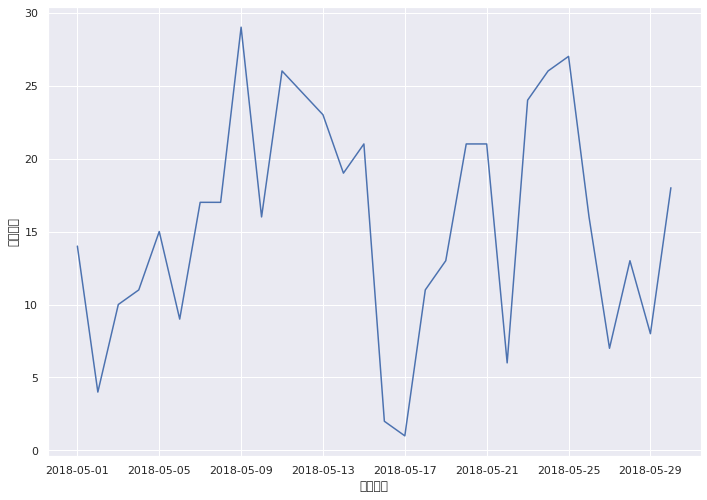

In [13]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x='기준일자', y='대여건수', data=U2318_may.toPandas())
plt.show()

___
## <대여소정보>


 - 지역별(구 단위) 따릉이 대여소의 총 수/가장 많은 곳/가장 적은 곳는?

In [14]:
df_loc.groupBy('구명') \
      .count() \
      .orderBy('count') \
      .show()

+--------+-----+
|    구명|count|
+--------+-----+
|  도봉구|   31|
|  용산구|   37|
|  강북구|   37|
|    중구|   38|
|  동작구|   41|
|  금천구|   42|
|동대문구|   49|
|  양천구|   51|
|서대문구|   51|
|  관악구|   51|
|  중랑구|   52|
|  구로구|   56|
|  성북구|   56|
|  광진구|   57|
|  강동구|   57|
|  은평구|   60|
|  성동구|   62|
|  종로구|   63|
|  노원구|   66|
|  마포구|   75|
+--------+-----+
only showing top 20 rows



In [15]:
df_loc.groupBy('구명') \
      .count() \
      .orderBy('count', ascending=False) \
      .show()

+--------+-----+
|    구명|count|
+--------+-----+
|  강남구|   95|
|  서초구|   87|
|  송파구|   86|
|영등포구|   84|
|  강서구|   76|
|  마포구|   75|
|  노원구|   66|
|  종로구|   63|
|  성동구|   62|
|  은평구|   60|
|  강동구|   57|
|  광진구|   57|
|  성북구|   56|
|  구로구|   56|
|  중랑구|   52|
|  관악구|   51|
|서대문구|   51|
|  양천구|   51|
|동대문구|   49|
|  금천구|   42|
+--------+-----+
only showing top 20 rows



In [16]:
result = df_loc.select('구명') \
               .toPandas()

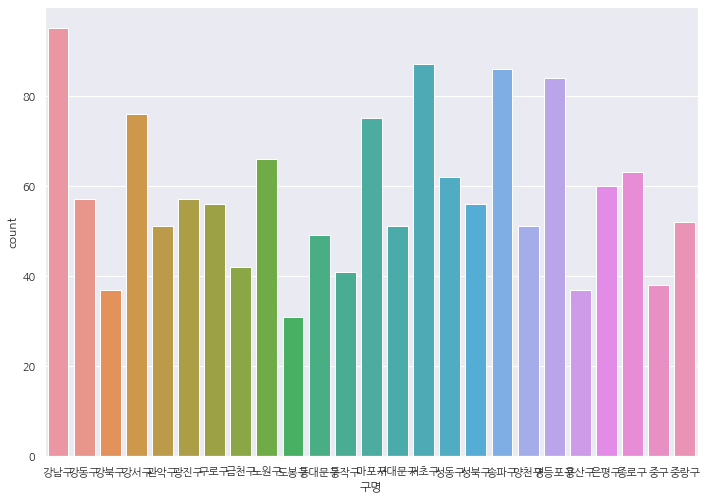

In [17]:
### for Linux
import matplotlib as mpl
import matplotlib.pylab as plt
import matplotlib.font_manager as fm
import seaborn as sns

fm._rebuild()
fontname = fm.FontProperties(fname='/usr/share/fonts/truetype/nanum/NanumGothic.ttf').get_name()
mpl.rc('font', family = fontname)
mpl.rcParams['axes.unicode_minus'] = False

sns.countplot(x='구명', data=result)
plt.show()

In [17]:
df_loc.groupBy('구명').count().orderBy('count', ascending=True).take(1)

[Row(구명='도봉구', count=31)]

 - 지역별(구 단위) 따릉이 거치대의 총 수/가장 많은 곳/가장 적은 곳는?

In [18]:
df_loc.groupBy('구명').sum('거치대수').orderBy('sum(거치대수)', ascending=False).show()

+--------+-------------+
|    구명|sum(거치대수)|
+--------+-------------+
|  서초구|         1214|
|영등포구|         1191|
|  강남구|         1150|
|  송파구|         1130|
|  마포구|         1025|
|  강서구|          884|
|  노원구|          840|
|  성동구|          771|
|  강동구|          763|
|  광진구|          720|
|  종로구|          706|
|  성북구|          687|
|  은평구|          671|
|  구로구|          661|
|서대문구|          643|
|동대문구|          633|
|  관악구|          632|
|  양천구|          628|
|  중랑구|          616|
|  용산구|          523|
+--------+-------------+
only showing top 20 rows



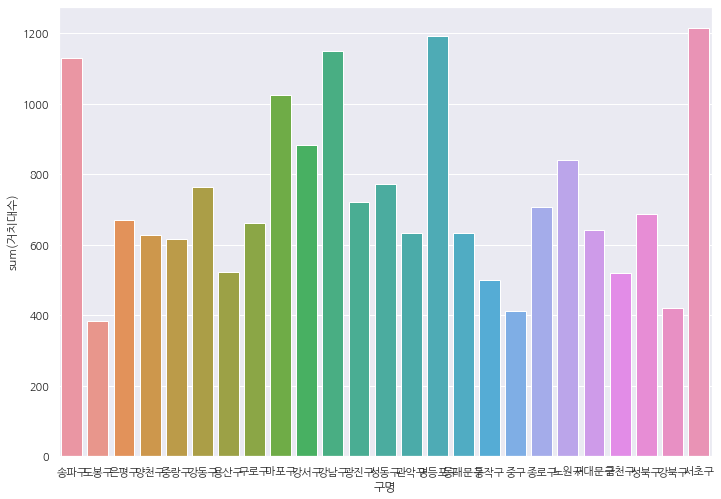

In [19]:
result = df_loc.groupBy('구명').sum('거치대수').toPandas()
sns.barplot(x="구명", y="sum(거치대수)", data=result)
plt.show()

In [20]:
df_loc.groupBy('구명').sum('거치대수').orderBy('sum(거치대수)', ascending=False).take(1)

[Row(구명='서초구', sum(거치대수)=1214)]

In [21]:
df_loc.groupBy('구명').sum('거치대수').orderBy('sum(거치대수)', ascending=True).take(1)

[Row(구명='도봉구', sum(거치대수)=383)]

In [22]:
# .alias를 사용하면 column에 이름 지정 가능
import pyspark.sql.functions as sf
df_loc.groupBy('구명')\
    .agg(sf.sum("거치대수").alias('총거치대수'))\
    .orderBy('총거치대수', ascending=False)\
    .take(1)

[Row(구명='서초구', 총거치대수=1214)]

___
## <위치별 대여수 정보>

 - 총 데이터 누적 기준 가장 많은 따릉이가 대여/반납된 대여소는?

In [23]:
df_usage.groupBy('대여소명')\
    .agg(sf.sum("대여건수").alias('총대여건수'))\
    .orderBy('총대여건수', ascending=False)\
    .show()

+-----------------------------+----------+
|                     대여소명|총대여건수|
+-----------------------------+----------+
|   207. 여의나루역 1번출구 앞|    159695|
| 502. 뚝섬유원지역 1번출구 앞|    121702|
|   113. 홍대입구역 2번출구 앞|    116752|
|     152. 마포구민체육센터 앞|     65325|
|       106. 합정역 7번출구 앞|     61311|
|1210. 롯데월드타워(잠실역2...|     58136|
|         358. 성대입구 사거리|     56064|
|             419. 홈플러스 앞|     55478|
|          2102. 봉림교 교통섬|     55299|
|           501. 광진구의회 앞|     54803|
|  2219. 고속터미널역 8-1번...|     53845|
|       102. 망원역 1번출구 앞|     53573|
|             421. 마포구청 앞|     52964|
|      247. 당산역 10번출구 앞|     52780|
|   114. 홍대입구역 8번출구 앞|     51866|
|     211. 여의도역 4번출구 옆|     51856|
|    511. 서울숲역 4번 출구 옆|     50123|
|             311. 서울광장 옆|     49499|
|             907. CJ 드림시티|     49412|
|         409. 누리꿈스퀘어 옆|     48941|
+-----------------------------+----------+
only showing top 20 rows



 - 총 데이터 누적 기준 가장 많은 따릉이가 대여/반납된 구는?

In [24]:
df_usage.groupBy('대여소위치')\
    .agg(sf.sum("대여건수").alias('총대여건수'))\
    .orderBy('총대여건수', ascending=False)\
    .show()

+----------+----------+
|대여소위치|총대여건수|
+----------+----------+
|    마포구|   2116691|
|  영등포구|   1836859|
|    종로구|   1309361|
|    성동구|   1035122|
|    광진구|   1017865|
|    송파구|    820438|
|  서대문구|    810534|
|  동대문구|    651099|
|      중구|    631085|
|    서초구|    568709|
|    강남구|    531907|
|    노원구|    492055|
|    은평구|    491372|
|    강서구|    474419|
|    관악구|    454347|
|    용산구|    408850|
|    구로구|    400180|
|    강동구|    388399|
|    성북구|    371708|
|    동작구|    361097|
+----------+----------+
only showing top 20 rows



 - 총 데이터 누적 기준 따릉이 대여와 반납의 차이가 가장 큰 대여소/구는?

In [25]:
df_usage.withColumn('대여차이', df_usage['대여건수']-df_usage['반납건수']).take(1)

[Row(대여소위치='동작구', 대여소명='2067. LG전자 베스트샾 대리점 앞', 기준일자=datetime.datetime(2018, 11, 30, 0, 0), 대여건수=16, 반납건수=11, 대여차이=5)]

In [26]:
df_usage.withColumn('대여차이', df_usage['대여건수']-df_usage['반납건수']) \
    .groupBy('대여소위치')\
    .agg(sf.sum("대여차이").alias('총대여차이'))\
    .orderBy('총대여차이', ascending=False)\
    .take(1)

# 대여소위치만 대여소명 으로 바꾸면?

[Row(대여소위치='종로구', 총대여차이=69789)]

## <일자별/월별 대여수 정보>

 - 2018년 전체 대여소 중 7/8/9/10월의 평균/일최대 따릉이 대여수는?

In [27]:
# between은 경계 양쪽 모두 포함
df_usage.where(df_usage['기준일자'].between('2018-07-01', '2018-07-31'))\
    .groupBy('기준일자')\
    .agg(sf.avg('대여건수').alias('평균대여건수'))\
    .orderBy('평균대여건수', ascending=False)\
    .show()

df_usage.where(df_usage['기준일자'].between('2018-07-01', '2018-07-31'))\
    .groupBy('기준일자')\
    .agg(sf.max('대여건수').alias('최대대여건수'))\
    .orderBy('최대대여건수', ascending=False)\
    .take(1)

# 문제 조건에 맞게 날짜 수정해보기

+-------------------+------------------+
|           기준일자|      평균대여건수|
+-------------------+------------------+
|2018-07-06 00:00:00| 39.23771790808241|
|2018-07-08 00:00:00|38.198412698412696|
|2018-07-07 00:00:00| 38.07692307692308|
|2018-07-04 00:00:00| 36.15810276679842|
|2018-07-13 00:00:00|35.579905063291136|
|2018-07-12 00:00:00|34.447867298578196|
|2018-07-17 00:00:00| 34.32646592709984|
|2018-07-18 00:00:00| 33.81349206349206|
|2018-07-19 00:00:00| 33.58095238095238|
|2018-07-03 00:00:00| 32.81428571428572|
|2018-07-16 00:00:00| 32.45800316957211|
|2018-07-20 00:00:00| 32.01587301587302|
|2018-07-05 00:00:00|31.465612648221345|
|2018-07-25 00:00:00| 31.10071371927042|
|2018-07-14 00:00:00| 31.04117181314331|
|2018-07-23 00:00:00|30.251592356687897|
|2018-07-26 00:00:00|29.901107594936708|
|2018-07-24 00:00:00| 29.69651347068146|
|2018-07-30 00:00:00| 29.01106719367589|
|2018-07-11 00:00:00|27.978656126482214|
+-------------------+------------------+
only showing top 20 rows



[Row(기준일자=datetime.datetime(2018, 7, 8, 0, 0), 최대대여건수=508)]

 - 지역별 월별 따릉이 대여/반납 누적 수는?

In [28]:
# 월별 컬럼 따로따로 생성
df_usage.select('대여소위치', '대여건수',
                sf.split('기준일자', '-')[1].alias('월'))\
        .groupBy('대여소위치')\
        .pivot('월')\
        .agg(sf.sum('대여건수'))\
        .show()

# 대여건수를 반납건수로 바꾸면?

+-----------+-----+-----+------+------+------+------+------+------+------+------+------+-----+
| 대여소위치|   01|   02|    03|    04|    05|    06|    07|    08|    09|    10|    11|   12|
+-----------+-----+-----+------+------+------+------+------+------+------+------+------+-----+
|     송파구| 7046| 7762| 26086| 39012| 72061| 95020| 81283| 84137|150308|154568| 94097| 9058|
|     도봉구|  824| 1095|  3858|  6402| 11705| 16167| 14548| 14773| 22740| 21128| 14245|  865|
|     은평구| 8951| 8747| 22269| 36780| 50266| 59462| 48133| 51134| 70288| 75081| 49335|10926|
|     양천구| 3427| 3813| 11632| 19379| 30490| 38638| 34560| 37894| 55911| 55269| 36038| 4266|
|     중랑구| 2960| 3308| 10128| 16254| 27224| 37643| 34615| 35927| 55004| 52160| 34212| 3622|
|     강동구| 3511| 3698| 11366| 18036| 36214| 49566| 43763| 44393| 66775| 65213| 41632| 4232|
|     용산구| 5363| 6264| 16708| 27379| 40678| 47352| 36795| 45704| 73170| 66756| 35479| 7202|
|     구로구| 4011| 4389| 12530| 20182| 31453| 49543| 45447| 46611| 67161| 6883

___
## <테이블조인>

 - 거치대 수 대비 따릉이 대여/반납 비율이 가장 높은 대여소/구는?

In [29]:
# df_usage의 대여/반납건수와 df_loc의 거치대수 정보가 모두 필요
# 두 테이블에 모두 있는 대여소 번호를 이용해 join
# df_usage 대여소명 컬럼에서 대여소 번호만 추출하여 사용

df_usage2 = df_usage.select('대여소위치', '대여건수', '반납건수', sf.split('대여소명', '\.')[0].alias('대여소번호'))
df_usage2.show()

+----------+--------+--------+----------+
|대여소위치|대여건수|반납건수|대여소번호|
+----------+--------+--------+----------+
|    동작구|      16|      11|      2067|
|    양천구|      30|      27|       726|
|    양천구|      14|       5|       725|
|    양천구|       3|       0|       724|
|    양천구|      38|      44|       723|
|    양천구|      29|      28|       722|
|    마포구|      11|      22|       426|
|    마포구|      14|      11|       425|
|    마포구|       2|       3|       424|
|    광진구|      63|      75|       502|
|    광진구|      19|      20|      3505|
|    광진구|      38|      33|      3504|
|    광진구|       8|      15|      3502|
|    광진구|      46|      36|      3501|
|    광진구|      24|      28|      3500|
|    송파구|       6|       8|      1250|
|    광진구|      23|      28|       593|
|    광진구|      32|      30|       501|
|    종로구|      14|       6|       451|
|    종로구|      24|      22|       450|
+----------+--------+--------+----------+
only showing top 20 rows



In [30]:
# 두 테이블에 모두 존재하는 대여소만 쓰기 위해 left join 대신 inner join
df_joined = df_usage2.join(df_loc.select('대여소번호', '거치대수', '대여소명', '위도'),
                           on='대여소번호', how='inner')\

df_joined.show()

+----------+----------+--------+--------+--------+---------------------------+---------+
|대여소번호|대여소위치|대여건수|반납건수|거치대수|                   대여소명|     위도|
+----------+----------+--------+--------+--------+---------------------------+---------+
|      2067|    동작구|      16|      11|      10|  LG전자 베스트샾 대리점 앞|37.497669|
|       726|    양천구|      30|      27|      15|   목동3단지 시내버스정류장|37.534389|
|       725|    양천구|      14|       5|      15|        양강중학교앞 교차로|37.524334|
|       724|    양천구|       3|       0|      15|계남공원 입구 주출입구 좌측|37.510681|
|       723|    양천구|      38|      44|      15|                  SBS방송국|37.529163|
|       722|    양천구|      29|      28|      10|      LG전자베스트샵 신정점|37.521435|
|       426|    마포구|      11|      22|      10|           서울신용보증재단|37.549061|
|       425|    마포구|      14|      11|      10|            DMC첨단산업센터|37.584503|
|       424|    마포구|       2|       3|      15|롯데하이마트 (상암월드컵점)| 37.57362|
|       502|    광진구|      63|      75|      27|    뚝섬유원지역 1번출구 앞| 3

In [31]:
df_joined_grouped = df_joined.groupBy('대여소명') \
                             .agg(sf.sum('대여건수').alias('총대여건수'), sf.avg('거치대수').alias('평균거치대수'))\
    
df_joined_grouped.withColumn('대여비율', df_joined_grouped['총대여건수']/df_joined_grouped['평균거치대수']) \
                 .orderBy('대여비율', ascending=False) \
                 .show()

# 대여소명 -> 대여소위치, 대여건수 -> 반납건수 로 바꾸면?

+----------------------------+----------+------------+-----------------+
|                    대여소명|총대여건수|평균거치대수|         대여비율|
+----------------------------+----------+------------+-----------------+
|신한은행 서교동금융센터점 앞|     45128|         5.0|           9025.6|
|         일진아이윌아파트 옆|     36376|         5.0|           7275.2|
|                 마포구청 앞|     52964|         8.0|           6620.5|
|           합정역 7번출구 앞|     61311|        10.0|           6131.1|
|  군자역 7번출구 베스트샵 앞|     45806|         8.0|          5725.75|
|          신자초교입구교차로|     27856|         5.0|           5571.2|
|           시청역 1번출구 뒤|     36977|         7.0|5282.428571428572|
|    성수사거리 버스정류장 앞|     35525|         7.0|           5075.0|
|               혜화동 로터리|     39685|         8.0|         4960.625|
|           합정역 5번출구 앞|     24719|         5.0|           4943.8|
|                 CJ 드림시티|     49412|        10.0|           4941.2|
|            DMC역 9번출구 앞|     48695|        10.0|           4869.5|
|   어린이대공원역 3번출구 앞

 - 따릉이 대여가 100건 이상 이루어진 경우가 있는 대여소 중 가장 남쪽에 있는 대여소는?

In [33]:
# 앞에서 생성한 df_joined dataframe 활용

df_joined.where(df_joined['대여건수'] >=100) \
         .orderBy('위도', ascending=True) \
         .show()

+----------+----------+--------+--------+--------+------------------------------------+---------+
|대여소번호|대여소위치|대여건수|반납건수|거치대수|                            대여소명|     위도|
+----------+----------+--------+--------+--------+------------------------------------+---------+
|      1820|    금천구|     154|     253|      10|       신한은행 시흥대로금융센터지점| 37.44334|
|      1816|    금천구|     181|     150|      20|                     금천폭포공원 앞|37.446861|
|      2203|    서초구|     190|     135|      20|                청계산입구역 2번출구|37.447659|
|      2202|    서초구|    1054|    1082|      20|                청계산입구역 1번출구|37.448936|
|      2270|    서초구|     238|     252|      10|                  서초포레스타 7단지|37.448967|
|      1821|    금천구|     243|     314|      10|홈플러스 시흥점 맞은편 다비치안경 앞|37.451458|
|      1822|    금천구|     405|     456|      10|                서울 시흥동우체국 앞|37.452991|
|      2201|    서초구|     155|     174|      20|                    본마을 정류소 앞|37.453281|
|      2205|    서초구|     587|     548|      15|      